In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
import mpl_lego as mplego
import pandas as pd

from hatespeech import keys, utils
from IPython.display import Markdown
from scipy.stats import bootstrap, kruskal

%matplotlib inline

In [5]:
mplego.style.use_latex_style()

In [6]:
exp = "08"
base_path = os.path.join(os.environ['HOME'], 'projects/hatespeech-2021-fairml')
data_path = os.path.join(os.environ['HOME'], 'data/hatespeech/clean_qualtrics_irt_rollout.feather')
rater_quality_path = "~/data/hatespeech/rater_quality_check.csv"
results_path = os.path.join(base_path, f'scaling/experiments/exp{exp}')
out_path = os.path.join(results_path, f"exp{exp}_out.txt")

In [7]:
with open(out_path) as f:
    lines = f.readlines()

In [8]:
bias_lines = lines[26223:26287]

In [18]:
lines[26220]

'|Observd  Expctd  Observd  Obs-Exp| Bias+  Model                    |Infit Outfit|    TargetRace               AnnotatorRace            |\n'

In [10]:
races = {
    'asian': 3,
    'black': 1,
    'latinx': 2,
    'middleeastern': 4,
    'nativeamerican': 5,
    'pacificislander': 6,
    'white': 0,
    'other': 7
}
sorted_races = list(np.array(list(races.keys()))[np.argsort(list(races.values()))])

In [30]:
n_samples = len(bias_lines)
observed = np.zeros(n_samples)
expected = np.zeros(n_samples)
bias_size = np.zeros(n_samples)
std_error = np.zeros(n_samples)
t_stats = np.zeros(n_samples)
p_vals = np.zeros(n_samples)
target = np.zeros(n_samples, dtype=str)
annotator = np.zeros(n_samples, dtype=str)
biases = np.zeros((8, 8))
std_errors = np.zeros((8, 8))
p_values = np.zeros((8, 8))

for idx, line in enumerate(bias_lines):
    processed = line.replace('|', ' ').replace('>', ' ').replace('<', ' ').split()
    observed[idx] = float(processed[0])
    expected[idx] = float(processed[1])
    bias_size[idx] = float(processed[4])
    std_error[idx] = float(processed[5])
    t_stats[idx] = float(processed[6])
    p_vals[idx] = float(processed[8])
    target[idx] = processed[13]
    annotator[idx] = processed[16]

    ii = races[line[88:105].replace(' ', '')]
    jj = races[line[112:132].replace(' ', '')]
    biases[ii, jj] = float(processed[4])
    std_errors[ii, jj] = float(processed[5])
    p_values[ii, jj] = float(processed[8])

In [32]:
log_odds = np.exp(np.diag(biases))
upper_bound = np.exp(np.diag(biases) + np.diag(std_errors))
lower_bound = np.exp(np.diag(biases) - np.diag(std_errors))
upper_error = upper_bound - log_odds
lower_error = log_odds - lower_bound

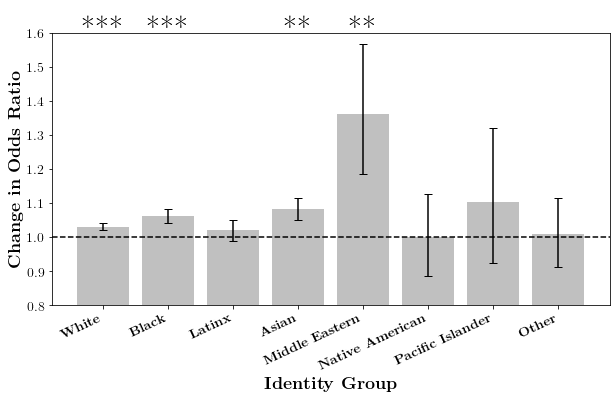

In [57]:
"""
Figure 3
"""
width = 0.2
spacing = 0.18
axis_label_size = 18
axis_tick_label_size = 14
subplot_label_size = 22
error_capsize = 4

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.bar(x=np.arange(8),
       height=log_odds,
       color='silver',
       yerr=np.concatenate(([lower_error], [upper_error]), axis=0),
       error_kw={'capsize': error_capsize})
ax.set_xticks(np.arange(8))
ax.set_xticklabels(
    [r'\textbf{White}',
     r'\textbf{Black}',
     r'\textbf{Latinx}',
     r'\textbf{Asian}',
     r'\textbf{Middle Eastern}',
     r'\textbf{Native American}',
     r'\textbf{Pacific Islander}',
     r'\textbf{Other}'],
    ha='right',
    rotation=25,
    fontsize=15)
ax.set_xlabel(r'\textbf{Identity Group}', fontsize=axis_label_size)
ax.set_ylabel(r'\textbf{Change in Odds Ratio}', fontsize=axis_label_size)
ax.set_ylim([0.80, 1.6])
ax.axhline(1, linestyle='--', color='black')
ax.text(x=0, y=1.64, s='***', va='center', ha='center', fontsize=30)
ax.text(x=1, y=1.64, s='***', va='center', ha='center', fontsize=30)
ax.text(x=3, y=1.64, s='**', va='center', ha='center', fontsize=30)
ax.text(x=4, y=1.64, s='**', va='center', ha='center', fontsize=30)

ax.tick_params(labelsize=axis_tick_label_size)
plt.savefig('figure5.pdf', bbox_inches='tight')